## Import de Bibliotecas

In [98]:
import seaborn as sns #graficos
import tweepy #utilizada para o twiter
import pandas as pd #tratamento de dados em tabelas
import matplotlib.pyplot as plt #graficos
from unidecode import unidecode #tratamento de texto
import nltk #NLP
from nltk.corpus import stopwords #lib de palavras muito frequentes
from nltk.tokenize import word_tokenize #transforma palavras em texto
from wordcloud import WordCloud #Nuvem de palavras
from sklearn.feature_extraction.text import CountVectorizer #Conta e vetoriza texto
from sklearn.decomposition import LatentDirichletAllocation #Geração de topicos

In [ ]:
## Input de informações

In [99]:
tema=input('Digite um tema: ')
qtd_topicos=int(input('Digite a quantidade de topicos: '))
lista_topicos = list()
for i in range(0, qtd_topicos):
    lista_topicos.append(input(f'Digite o topico {i} a ser analisado: '))
session_token=input('Digite o bearer token do app: ')

Digite um tema: palmeiras
Digite a quantidade de topicos: 4
Digite o topico 0 a ser analisado: abel
Digite o topico 1 a ser analisado: leila
Digite o topico 2 a ser analisado: endrick
Digite o topico 3 a ser analisado: mancha


## API Twitter

#### Definindo Credenciais

In [100]:
session_token = 'AAAAAAAAAAAAAAAAAAAAAMaXXwEAAAAAPPYlMJDXgHUfZf3MNwxLdAim19A%3Ds3FLZWG1g2jjUI8quRAv49gWKVpnyYx6X0HfGCxcWsZyiC8XKj'

#### Extraindo Dados do twitter

In [101]:
#Autenticando o token do cliente na api do twitter
client = tweepy.Client(bearer_token=session_token)

"""
If you don't understand search queries, there is an excellent introduction to it here: 
https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
"""

# Obtem os tweets que contém a #tema
# -is:retweet significa que não quero retweets
# lang:pt define busca por tweets em portugues
query = f'#{tema} lang:pt -is:retweet'

#Realizando extração dos tweets
tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                              tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=10000)

# Criando esqueleto do dataframe
lista_text=[]
lista_id=[]
lista_data=[]
for tweet in tweets:
    lista_id.append(tweet.id)
    lista_text.append(tweet.text)
    lista_data.append(tweet.created_at)

#### Criando Base do Twitter

In [102]:
df_tweet = pd.DataFrame()

In [103]:
df_tweet['ID']=lista_id
df_tweet['Data']=lista_data
df_tweet['Text']=lista_text

#### Eliminando tweets que contenham RT

In [104]:
df_tweet['RT']=df_tweet.apply(lambda row:True if row['Text'].startswith('RT') else False, axis=1)

In [ ]:
#### Avaliando data máxima e data mínima

In [105]:
print('Data máxima: ', df_tweet['Data'].max())

Timestamp('2022-10-09 14:45:54+0000', tz='UTC')

In [106]:
print('Data mínima: ', df_tweet['Data'].min())

Timestamp('2022-10-02 15:12:00+0000', tz='UTC')

#### Criando campo de anomesdia

In [107]:
df_tweet['anomesdia']=df_tweet['Data'].apply(lambda row: int(row.strftime('%Y%m%d')))

In [108]:
# df_tweet.to_excel('Amostra_twitter.xlsx', index=False)

## Análise Exploratória

#### Realizando Leitura da Base

In [109]:
# df_tweet = pd.read_excel('Amostra_twitter.xlsx')

#### Eliminando tweets com RT no texto

In [110]:
df_tweet = df_tweet[df_tweet['RT']!=True].reset_index(drop=True)

#### Criando colunas com os tópicos escolhidos pelo usuário

In [111]:
dict_analise = dict()

In [112]:
for topico in lista_topicos:
    df_tweet[topico]=df_tweet.apply(lambda row:True if topico.lower() in row['Text'].lower() else False, axis=1)

#### Criando planilha para geração de grafico comparativo dos topicos

In [113]:
qtd_tweets = []
for informacao in lista_topicos:
    qtd_tweets.append(df_tweet[df_tweet[informacao]==True].shape[0])

In [114]:
df_analise=pd.DataFrame(zip(lista_topicos, qtd_tweets), columns=['Topico', 'Qtd_Tweets'])

#### Comparando Informações por tipo

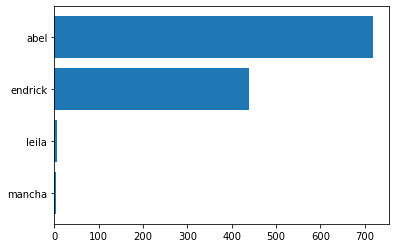

In [116]:
df_analise = df_analise.sort_values(['Qtd_Tweets'], ascending=True)
data = df_analise['Qtd_Tweets']
plt.barh(df_analise['Topico'], data)
plt.show()

#### Comparando tópicos por quantidade de citações

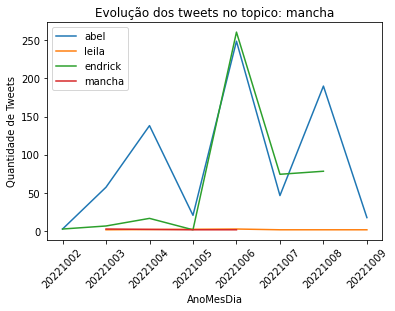

In [117]:
for topico in lista_topicos:
    df_analise_dia = df_tweet[df_tweet[topico]==True]
    df_analise_dia = pd.DataFrame(df_analise_dia.groupby('anomesdia')[topico].count()).reset_index()
    df_analise_dia['anomesdia']=df_analise_dia['anomesdia'].astype(str)
    plt.title('Evolução dos tweets no topico: '+topico)
    sns.lineplot(x="anomesdia", y=topico, data=df_analise_dia)
plt.legend(lista_topicos)
plt.ylabel('Quantidade de Tweets')
plt.xlabel('AnoMesDia')
plt.xticks(rotation=45)
plt.show()

# WordCloud por tópico

#### Tratando campo de texto da tabela

In [118]:
df_tweet['Text_tratado'] = df_tweet['Text'].apply(lambda row: unidecode(row.lower()).replace('\n', ''))

##### Removendo stopwords

In [119]:
stopwords = stopwords.words('portuguese')
stop_mais = ['rt', 'jovempanesporte', tema, 'ja', 'ter', 'acho', 'deu','libertadoresvirtual', 'estariam', 
             'feira', 'https', 'curta', 'marque', 'compartilhar', 'pessoas', 'tbm', 'dia', 'noite', 'nao', 'vai', 'voce', 
             'sao', '...', 'link']
for stop in stop_mais:
    stopwords.append(stop)

#### Função utilizada para remover stopwords do texto e limpar textos não necessários

In [120]:
def trata_texto(df, topico):
    df_aux = df_tweet[df_tweet[topico]==True]
    text=''
    for texto in df_aux['Text_tratado']:
        if text != '':
            text=text+' '+texto
        else:
            text=texto

    text = text.replace('abel ferreira', 'abel').replace('abelferreira', 'abel').replace('gustavo scarpa', 'scarpa').replace('gustavo gomez', 'gomez')
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords]

    filtered_sentence = []
    for w in word_tokens:
        if w not in stopwords and len(w)>2 and 't.co' not in w:
            filtered_sentence.append(w)
    text = filtered_sentence
    return text

#### Realizando contagem de palavras 

Gerando wordcloud do topico:  abel


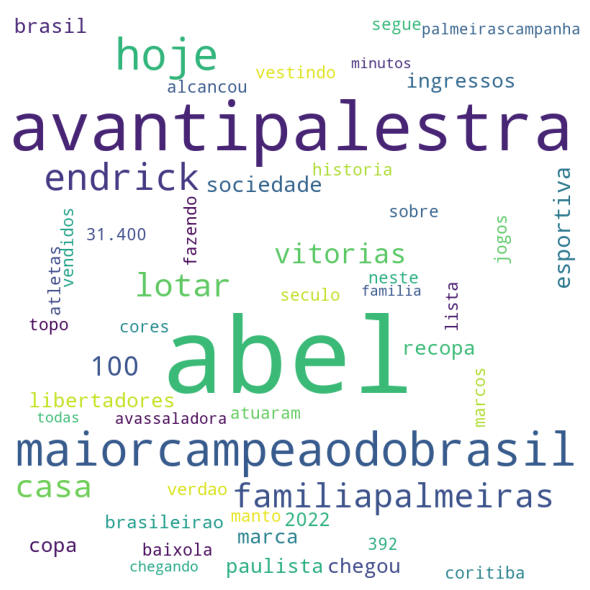

Gerando wordcloud do topico:  leila


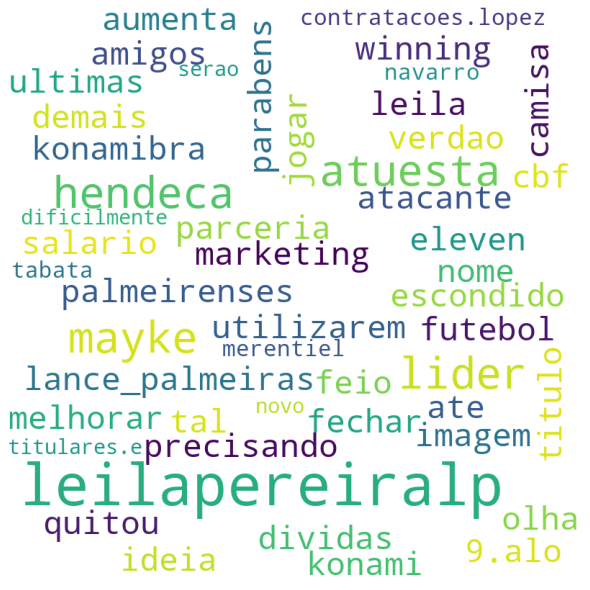

Gerando wordcloud do topico:  endrick


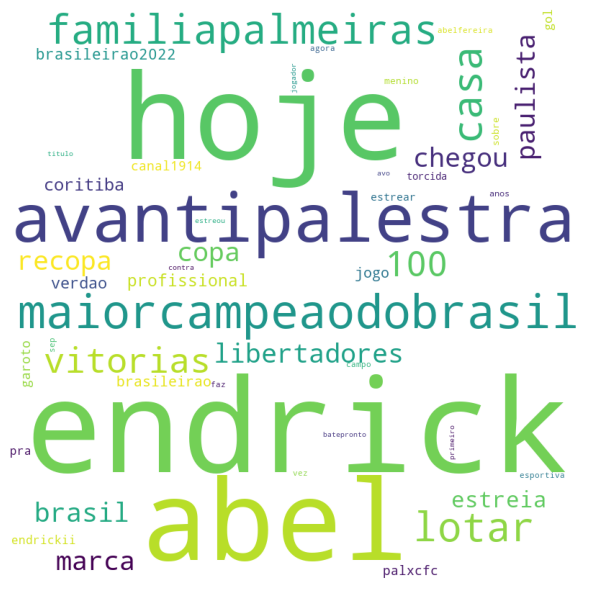

Gerando wordcloud do topico:  mancha


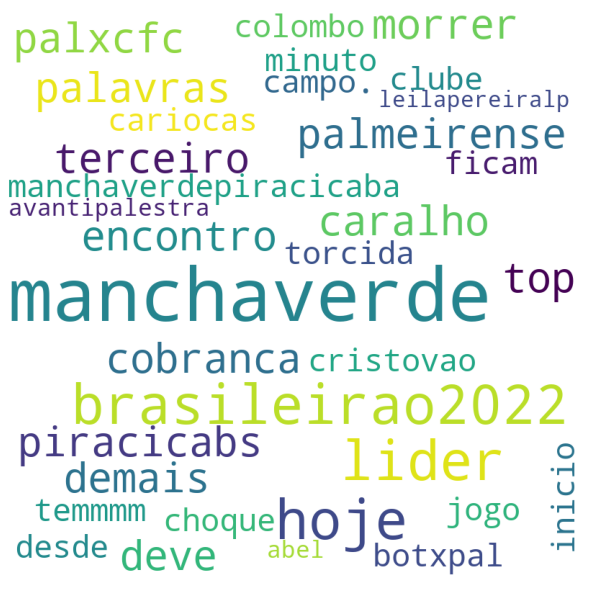

In [124]:
for topico in lista_topicos:
    print('Gerando wordcloud do topico: ', topico)
    
    # riando um dicionário de frequências
    dict_frequencias = dict()

    # Criando o texto tratado e unificado
    text = trata_texto(df_tweet['Text_tratado'], topico)
    # Adicionando valores das frequencias das palavras
    for word in text:
        if len(word)>2:
            # Verificando se a palavra existe no dicionário
            if word in dict_frequencias:
                # Adiciona mais um, caso a palavra exista
                dict_frequencias[word] = dict_frequencias[word] + 1
            else:
                # Cria a palavra adicionando a frequencia inicial =1
                dict_frequencias[word] = 1
    
#     #Cria um dataframe com as informações
#     df_frequencias = pd.DataFrame(zip(d.keys(), d.values()), columns=['Palavras', 'Qtd']).sort_values('Qtd', ascending=False)
    
    
# #     dict_frequencias = {}
# #     for i, row in df_frequencias.iterrows():
# #         dict_frequencias.update({row['Palavras']: row['Qtd']})

    #Configurando o wordcloud
    #tamanho: 800x800
    #cor de fundo: branca
    #tamanho mínimo da font:10
    #Quantidade máxima de palavras 50
    wordcloud = WordCloud(width = 800, height = 800,
                        background_color ='white',
                        min_font_size = 10, max_words=50)
    #Gerando wordcloud com dicionario de frequencias
    wordcloud.generate_from_frequencies(dict_frequencias)
    #define tamanho da figura
    plt.figure(figsize = (8, 8), facecolor = None)
    #Gera imagem
    plt.imshow(wordcloud)
    #remove o eixo
    plt.axis("off")
    plt.tight_layout(pad = 0)
    #imprime wordcloud
    plt.show()

## LDA

#### Gerando tópicos de análises através dos textos

In [122]:
#Criando texto vetorizado
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords)
dtm = cv.fit_transform(df_tweet['Text_tratado'])

#Utilizando o LDA para criar tópicos
LDA = LatentDirichletAllocation(n_components=qtd_topicos,random_state=42)
# Fitando os textos do LDA
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [123]:
#Criando um for para gerar os topicos
for index,topic in enumerate(LDA.components_):
    print(f'O TOP 15 PALAVRAS PARA O TOPICO #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['jogo', 'cfc', 'coxa', 'sep', 'brasileirao2022', 'coritiba', 'lotar', 'maiorcampeaodobrasil', 'abelferreira', 'casa', 'familiapalmeiras', 'avantipalestra', 'endrick', 'hoje', 'co']


THE TOP 15 WORDS FOR TOPIC #1
['2022', 'ferreira', 'brasileirao2022', 'avantipalestra', 'futebol', 'botxpal', 'sobre', 'time', 'verdao', 'canal1914', 'jogo', 'abel', 'botafogo', 'brasileirao', 'co']


THE TOP 15 WORDS FOR TOPIC #2
['juntosnobrasileirao', 'visitante', '63', 'maior', 'pontos', 'serie', 'botafogo', 'sociedade', 'esportiva', 'historia', 'brasileirao', 'verdao', 'maiorcampeaodobrasil', 'avantipalestra', 'co']


THE TOP 15 WORDS FOR TOPIC #3
['comecando', 'lideranca', 'vitoria', 'semana', 'brasileirao', 'busca', 'tres', 'sociedade', 'esportiva', 'jeito', 'pontos', 'juntosnobrasileirao', 'maiorcampeaodobrasil', 'avantipalestra', 'co']


THE TOP 15 WORDS FOR TOPIC #4
['recopa', 'marca', 'endrick', 'paulista', 'chegou', 'copa', 'libertadores', 'ferreira', 'brasil', 'm

C:\Users\mathe\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
